# OTE-09 analysis of stacked segments with FGS ID images

This notebook will be used during the rare case that we need to check the 3x3 count rates from the pseudo-FGS image created from the NIRCam image against FGS ID strips. This is expected to only be needed for the preparation for observations 6 and 11 of OTE-09.

IMPORTANT NOTE: To build this notebook I (K. Brooks) had to use simulated ID strips data from OTE-07 because we do not have any simulated ID strips data for OTE-09. This means that it is impossible to get any meaningful data from the notebook if run as is in the MAGIC repository. Where possible, I used the simulated NIRCam data from OTE-09, but did not have associated FGS ID data. Because of this, there is a chance that some of the cells may not run when the real data is used, trouble shoot as you can but call in help if you need it. 

In [22]:
import os
from functools import reduce
import logging
import shutil

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from IPython.display import Image

import fgscountrate
import jwst_magic
from jwst_magic.convert_image import convert_image_to_raw_fgs
from jwst_magic.utils import utils
PACKAGE_PATH = jwst_magic.__file__.split('jwst_magic/__init__.py')[0]

LOGGER = logging.getLogger('ote09-compare-count-rates-notebook')

%matplotlib inline

# Table of Contents
1. [About this Guide Star](#About-this-Guide-Star)
2. [Segment ID matching to MAGIC labeling](#Segment-ID-matching-to-MAGIC-labeling)
2. [Functions](#Functions)
3. [Before the start of Observation 6](#Before-the-start-of-Observation-6)
4. [Before the start of Observation 11](#Before-the-start-of-Observation-11)
5. [After Observation 11](#After-Observation-11)
6. [About this notebook](#About-this-notebook)

# About this Guide Star

Edit the cell below with the guider and Guide Star ID for these observations

In [108]:
guider = 1
guide_star_id = 'N4ED000133'

# Segment ID matching to MAGIC labeling
Run but do not change these cells

In [29]:
if guider==1:
    orientation_filename = "../Commissioning_Support/fgs_raw_orientation_numbering_wss_guider1.png"  
elif guider==2:
    orientation_filename="../Commissioning_Support/fgs_raw_orientation_numbering_wss_guider2.png"
    
magic_grid_filename = "../JWSTgrid_side.png"

In [33]:
print(f'Guider {guider}')

Guider 1


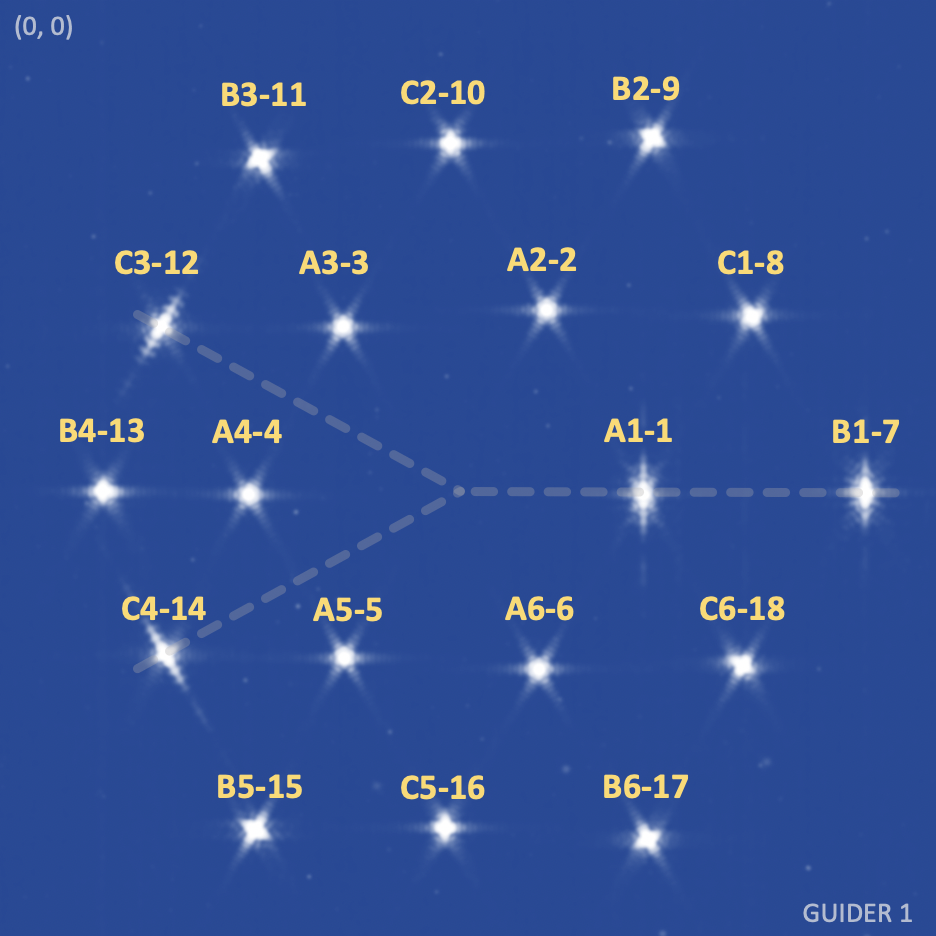

In [32]:
Image(filename=orientation_filename, height=400, width=400)

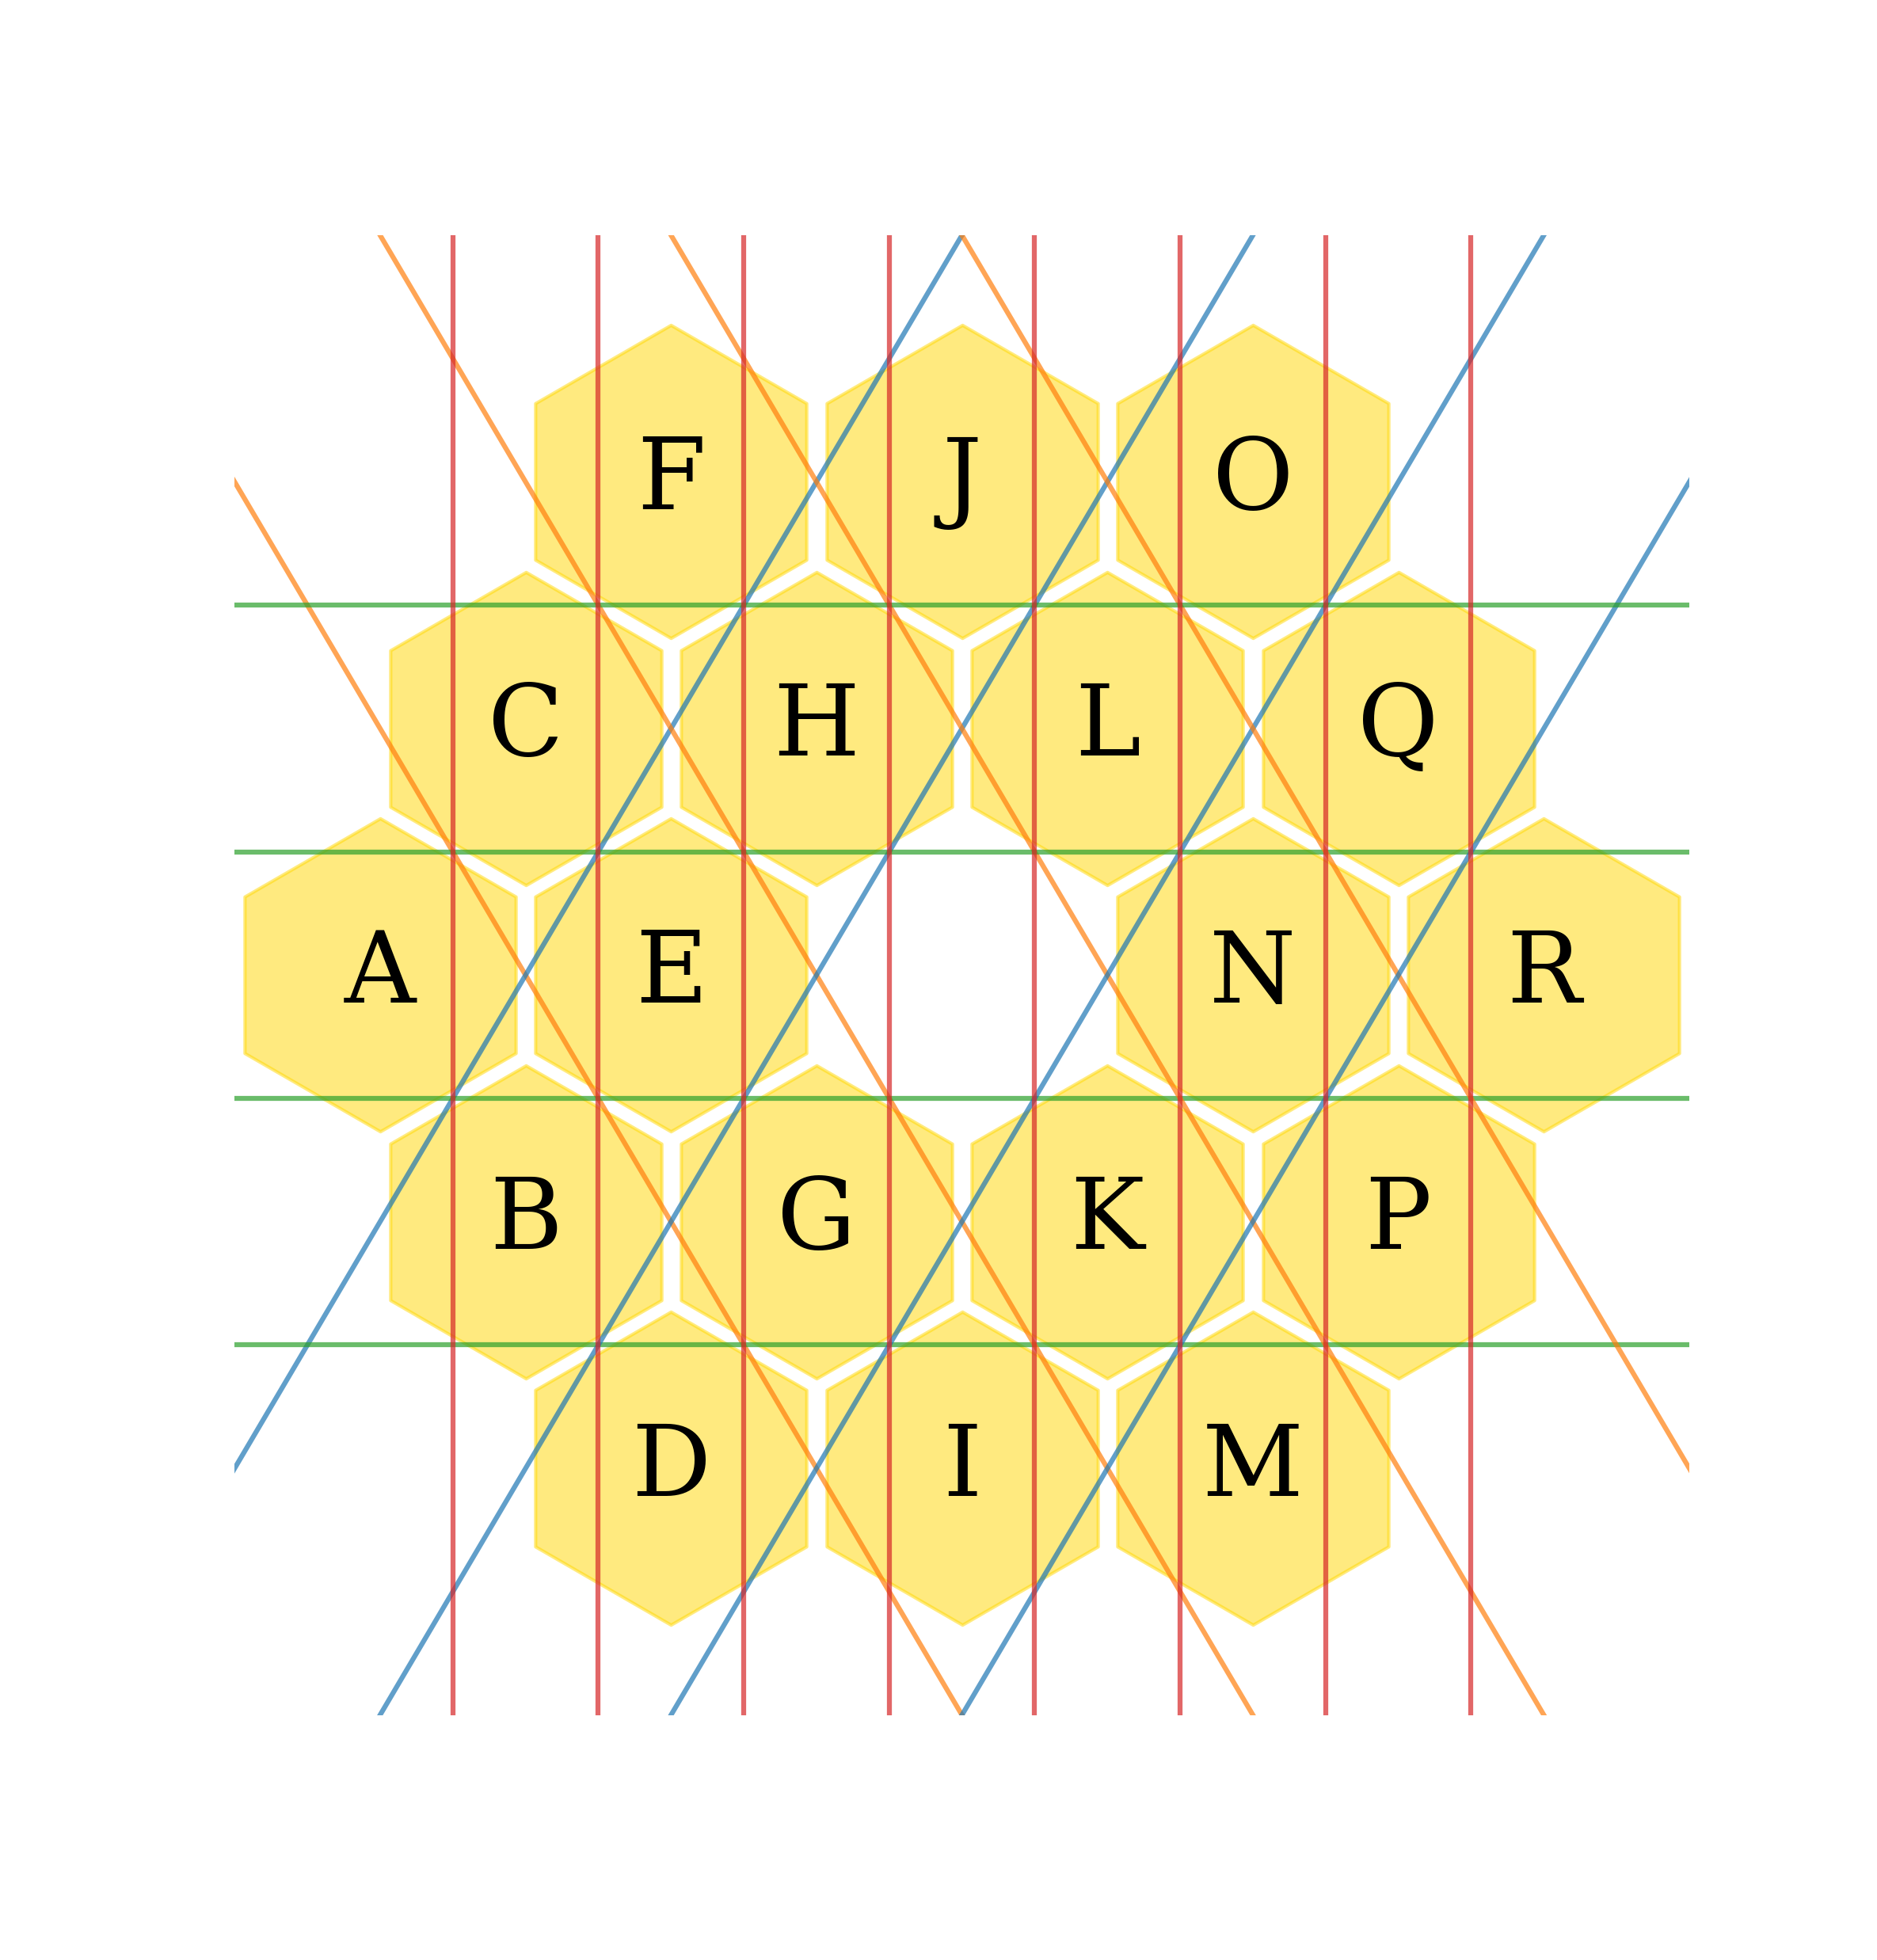

In [31]:
Image(filename=magic_grid_filename, height=400, width=400)

In [2]:
# MAGIC segment labels to segment naming G1 map
SEGMENT_MAP_G1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}

# MAGIC segment lbabels to segment naming G2 map
SEGMENT_MAP_G2 = {"A":"B1-7", "B":"C6-18", "C":"C1-8", "D":"B6-17",
                  "E":"A1-1", "F":"B2-9", "G":"A6-6", "H":"A2-2", 
                  "I":"C5-16", "J":"C2-10", "K":"A5-5", "L":"A3-3", 
                  "M":"B5-15", "N":"A4-4", "O":"B3-11", "P":"C4-14", 
                  "Q":"C3-12", "R":"B4-13"}

# Functions 
Do not change these cells

In [3]:
def calculate_percent_diff(cr1, cr2):
    """Calculate the percent difference between 2 count rates. cr1 is considered the truth value"""
    diff = (np.abs(cr1 - cr2)/cr1)*100
    return diff


In [4]:
def read_all_found_psfs(all_psfs_filename):
    """
    Read in the all found PSFs file from MAGIC and map the segment ID to the measured PSF. Return a data frame 
    (table) with the information in this file
    """
    # Read in all found PSFs
    segment_map = SEGMENT_MAP_G1 if guider==1 else SEGMENT_MAP_G2
    
    all_psfs_table = pd.read_csv(all_psfs_filename, comment='#', 
                                 names=['label', 'y', 'x', 'countrate'], sep=' ')
    segments = [segment_map[label] for label in all_psfs_table['label']]

    # Add the segment name to the table
    all_psfs_table.insert(1, 'segment', segments)
    all_psfs_table = all_psfs_table.sort_values('segment', ascending=True)
    
    return all_psfs_table

In [16]:
def convert_id_to_fgs_raw(input_image, root, out_dir, guider, smoothing):
    # Determine filename root
    root = utils.make_root(root, input_image)

    # Determine output directory
    out_dir_root = utils.make_out_dir(out_dir, PACKAGE_PATH, root)
    utils.ensure_dir_exists(out_dir_root)

    # Set up logging
    _, log_filename = utils.create_logger_from_yaml(__name__, out_dir_root=out_dir_root, root=root, level='DEBUG')

    LOGGER.info("Package directory: {}".format(PACKAGE_PATH))
    LOGGER.info("Processing request for {}.".format(root))
    LOGGER.info("All data will be saved in: {}".format(out_dir_root))
    LOGGER.info("Input image: {}".format(os.path.abspath(input_image)))

    # Copy input image into out directory
    try:
        shutil.copy(os.path.abspath(input_image), out_dir_root)
    except shutil.SameFileError:
        pass

    # Convert provided FGS ID image to a "raw" FGS image
    fgs_im, all_found_psfs_file, psf_center_file, fgs_hdr_dict = \
        convert_image_to_raw_fgs.convert_im(input_image, guider, root,
                                            out_dir=out_dir,
                                            nircam=False,
                                            nircam_det=None,
                                            normalize=False,
                                            smoothing=smoothing,
                                            coarse_pointing=False,
                                            jitter_rate_arcsec=None,
                                            logger_passed=True,
                                            itm=False)

    # Add logging information to fgs image header
    fgs_hdr_dict['LOG_FILE'] = (os.path.basename(log_filename), 'Log filename')

    # Write converted image
    convert_image_to_raw_fgs.write_fgs_im(fgs_im, out_dir, root, guider, fgs_hdr_dict)
    LOGGER.info("*** Image Conversion COMPLETE ***")


# Before the start of Observation 6

At the end of observation 5, you will have the NIRCam image from the end of observation 5, which you will run through MAGIC as normal. After you finish your DHAS testing and make your override file, download the `gs-id_1_image_cal.fits` for the end of observation 5 from MAST. The goal is to compare the 3x3 count rates for each segment PSF that you have selected for your guiding configurations that you get from the pseudo-FGS image from a NIRCam image, to that from the ID strips. The values from the ID strips is considered truth since it is an FGS image looking at the actual guide star. If these values **differ by more than 30%**, replace the commanded 3x3 count rate in the override file, with what is measured in the pseudo-FGS image made from the ID strips. 

The ID image that you have retrieved from MAST is a merged image that has been run through the pipeline and is in the SCI frame. It has a size of 2028x2024 so you will pad this image to a 2048x2048 image so that can be run through MAGIC to get out the 3x3 count rates for each PSF. We will also subtract off the average background, and cut out any background stars to make sure that this image doesn't run into any issues in MAGIC. 

In observation 7, 8, 9 and 10, we will have a similar configuration but with the B segments moving around in the image. Since we are guiding on the C segments, which do not move, we do not expect the count rates of each segment PSF to change from the number measured in the pseudo-FGS image made from the ID strips. For each of these observations, continue to check that the 3x3 count rates in your command do not differ from the "truth" value by more than 30%.

## Load in the ID strips merged image if it exists

If the `gs-id_1_image_cal.fits` exists in MAST for your observation, you want to use that one. This a merged ID strips image. It has the shape 2048x2024 so you will need to pad it by 24 rows of zeros. Since the positions of the PSFs don't matter in the image, this change will not negatively impact the data or our analysis. 

In [5]:
# Grab the *_gs-id_1_image_cal.fits image associated with your CAR/obs from MAST
# and provide the path to this image below

path_to_id_image_cal = '/Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits'

In [6]:
hdu = fits.open(path_to_id_image_cal)
hdu.info()

Filename: /Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        54   (2024, 2048, 1)   float32   
  2  ERR           1 ImageHDU        10   (2024, 2048, 1)   float32   
  3  DQ            1 ImageHDU        11   (2024, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


(1, 2048, 2024)


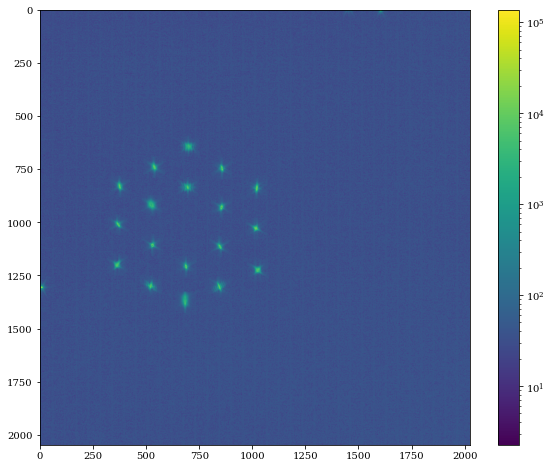

In [7]:
sci = fits.getdata(path_to_id_image_cal)
print(np.shape(sci))

plt.figure(figsize=(10, 8))
plt.imshow(sci[0], norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
bk_sub_sci = sci[0] - np.median(np.asarray(sci[0])) # Remove background as much as possible

center_of_array = (690, 1000) #Eye ball the center of the array
radius_of_window = 500

cropped = bk_sub_sci[center_of_array[1]-radius_of_window: center_of_array[1]+radius_of_window,
                     center_of_array[0]-radius_of_window: center_of_array[0]+radius_of_window]

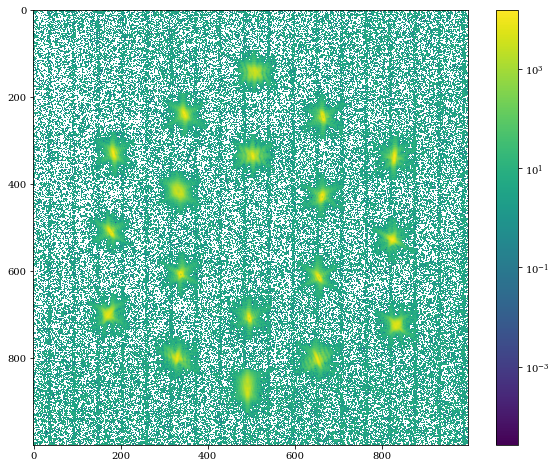

In [10]:
plt.figure(figsize=(10,8))
plt.imshow(cropped, norm=LogNorm())
plt.colorbar()
plt.show()

In [11]:
# Pad the image to a 2048x2048 image
pad = (2048 - (2*radius_of_window)) // 2
padded_sci = np.pad(cropped, pad, 'constant')

if np.shape(padded_sci) != (2048, 2048):
    print(f'The shape of the input data is not as expected ({np.shape(padded_sci)}, adjust the padding function accordingly')

In [12]:
# Make sure that the associated data is the same shape as the SCI image
err = hdu['ERR'].data
padded_err = np.pad(err[0], ((0,0), (12,12)), 'constant')
if np.shape(padded_err) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

dq = hdu['DQ'].data
padded_dq = np.pad(dq, ((0,0), (12,12)), 'constant')
if np.shape(padded_dq) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

In [13]:
# Put these back into the file that we will be using and write it out
hdu['SCI'].data = padded_sci
hdu['ERR'].data = padded_err
hdu['DQ'].data = padded_dq

path, filename = os.path.split(path_to_id_image_cal)
new_filename = f'expanded_{filename}'
outfile = os.path.join('/Users/kbrooks/Desktop', new_filename)
hdu.writeto(outfile, overwrite=True)

## Run this image through the backend of MAGIC to create a pseudo-FGS image 

In [14]:
# Input image and paths
input_image = outfile # This is the same image that you just wrote out
root = 'from_ote09_obs5_id'
out_dir = '/Users/kbrooks/Desktop/MAGIC/test/' # Change this path

# Smoothing information
smoothing = 'high' #"high" for large smoothing (e.g. Global Alignment), "default" for medium smoothing 

In [15]:
fits.info(input_image)

Filename: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        53   (2048, 2048)   float32   
  2  ERR           1 ImageHDU         9   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


In [17]:
# Create a peusdo-FGS image from the ID image
convert_id_to_fgs_raw(input_image, root, out_dir, guider, smoothing)

2021-12-30 10:26:25,697 - INFO - Started logging to file /Users/kbrooks/Desktop/MAGIC/test/out/from_ote09_obs5_id/2021_12_30_Thu_102625_main_from_ote09_obs5_id.log
2021-12-30 10:26:25,698 - INFO - Package directory: /Users/kbrooks/git_repos/jwst-magic-fork/
2021-12-30 10:26:25,698 - INFO - Processing request for from_ote09_obs5_id.
2021-12-30 10:26:25,699 - INFO - All data will be saved in: /Users/kbrooks/Desktop/MAGIC/test/out/from_ote09_obs5_id
2021-12-30 10:26:25,699 - INFO - Input image: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
2021-12-30 10:26:25,781 - INFO - Image Conversion: Beginning image conversion to guider 1 FGS image
2021-12-30 10:26:25,781 - INFO - Image Conversion: Input image is expected to be in units of ADU/sec (countrate)
2021-12-30 10:26:32,846 - INFO - Image Conversion: Bad pixels removed from image using DQ array from image.
2021-12-30 10:26:32,846 - INFO - Image Conversion: Image in correct units of ADU/s.
2021-12-30 10:26:32,858 - INF

In [18]:
# Make a table of the all found PSFs
all_psfs_filename_obs5 = os.path.join(out_dir, 'out', root, f'unshifted_all_found_psfs_{root}_G{guider}.txt')
all_psfs_table_obs5 = read_all_found_psfs(all_psfs_filename_obs5)

all_psfs_table_obs5

label segment       y       x    countrate
8      N    A1-1  1018.0  1189.0   92530.4463
4      L    A2-2   859.0  1095.0   98461.8320
5      H    A3-3   867.0   910.0   88735.8672
9      E    A4-4  1026.0   816.0   99237.4111
12     G    A5-5  1184.0   917.0   80349.1865
13     K    A6-6  1189.0  1106.0   34408.5588
7      R    B1-7  1014.0  1381.0   37693.9841
1      O    B2-9   693.0  1185.0  109606.0586
0      F   B3-11   688.0   800.0   58980.4243
10     A   B4-13  1031.0   654.0   44823.6899
17     D   B5-15  1350.0   824.0   67991.6616
15     M   B6-17  1338.0  1194.0  111133.5527
3      Q    C1-8   857.0  1278.0   91302.4785
2      J   C2-10   697.0   996.0  119059.1846
6      C   C3-12   869.0   721.0   87203.8560
14     B   C4-14  1192.0   724.0   75792.5586
16     I   C5-16  1345.0  1014.0   86409.3013
11     P   C6-18  1175.0  1284.0   95949.3027

### Do a quick visual check to make sure that the identified segments are correct 

In [19]:
pseudo_fgs_obs5 = fits.getdata(os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                                            f'unshifted_{root}_G{guider}.fits'))

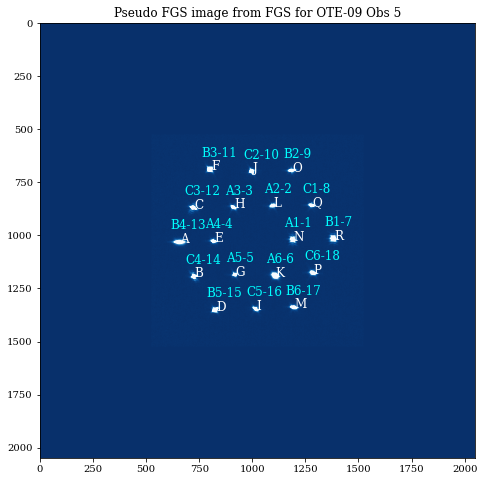

In [21]:
xs = all_psfs_table_obs5['x'].values
ys = all_psfs_table_obs5['y'].values
labels = all_psfs_table_obs5['label'].values
segments = all_psfs_table_obs5['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(pseudo_fgs_obs5, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from FGS for OTE-09 Obs 5")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-40, y-60), color='cyan', fontsize=12)
plt.show()

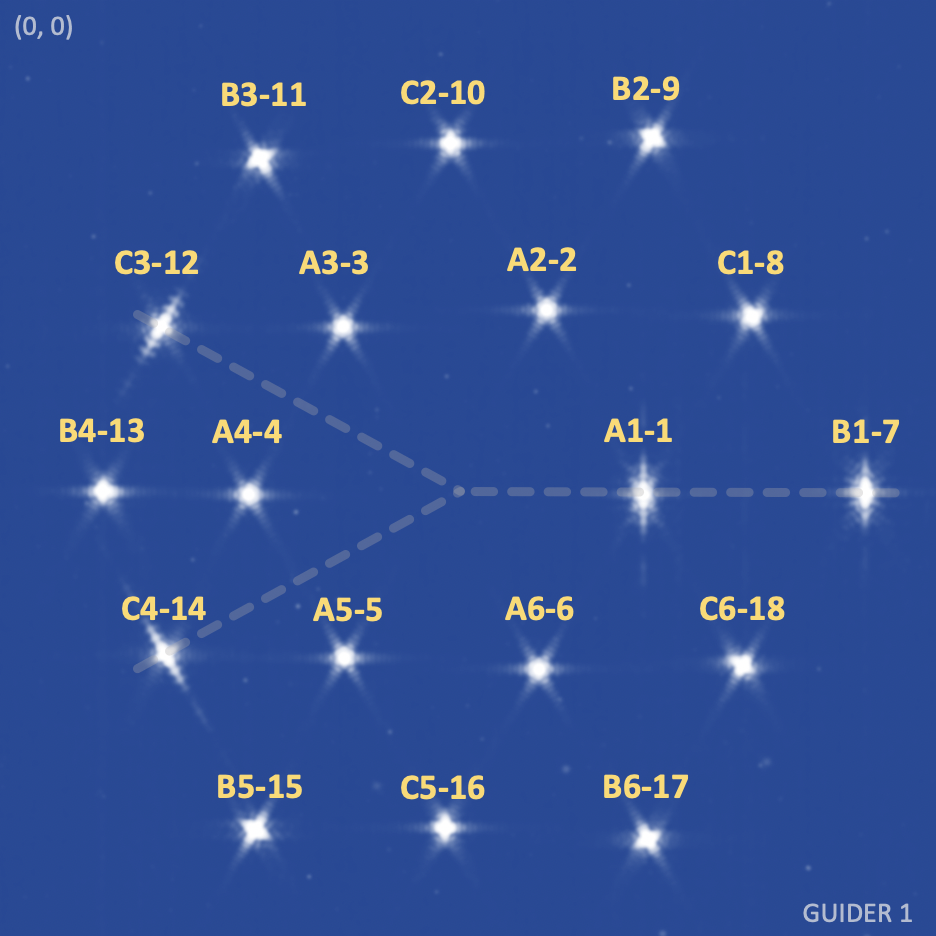

In [34]:
Image(filename=orientation_filename, height=400, width=400) 

In this case, note that `E` is actually all A segments stacked on top of each other. 

Confirm that the segments found are consistent with the diagrams above (depending on which guider is being used) and matches what is given in the all_psfs_table for the pseudo-FGS image from the ID strips. If you need to update the segment names in the table, you can do so by creating a list of the actual segment IDs in order as they appear in the table (for example called `actual_segments` and run a cell with the following lines of code: 
```
actual_segments = [,] # Fill in this list
all_psfs_table_obs5['segment'] = actual_segments
```

## Load in your commanded all found PSFs file

In [35]:
# Give the guider, root, and out directory for the commanded MAGIC data products
root = 'test-case2'
out_dir = '/Users/kbrooks/Desktop/MAGIC/test/'

# Make a similar table for the commanded values in the pseudo-FGS image made from the NIRCam image
commanded_all_psfs_filename_obs5 = os.path.join(out_dir, 'out', root, f'unshifted_all_found_psfs_{root}_G{guider}.txt')
#commanded_all_psfs_filename = '/Users/kbrooks/git_repos/jwst-magic-fork/out/mini_otb_oct/ote07/out/for_obs01/unshifted_all_found_psfs_for_obs01_G1.txt'

commanded_all_psfs_table_obs5 = read_all_found_psfs(commanded_all_psfs_filename_obs5)

commanded_all_psfs_table_obs5

label segment       y       x   countrate
3     E    A4-4  1007.0  1032.0  24312.1353
6     R    B1-7  1739.0  1049.0  11228.6666
4     O    B2-9  1358.0  1652.0  11782.3289
1     F   B3-11   653.0  1642.0   9606.1696
0     A   B4-13   296.0  1019.0   9403.8337
2     D   B5-15   680.0   403.0   7836.0065
5     M   B6-17  1395.0   408.0   8055.2964

### Do a quick visual check to make sure that the identified segments are correct 

In [36]:
commanded_pseudo_fgs_obs5 = fits.getdata(os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                                                 f'unshifted_{root}_G{guider}.fits'))

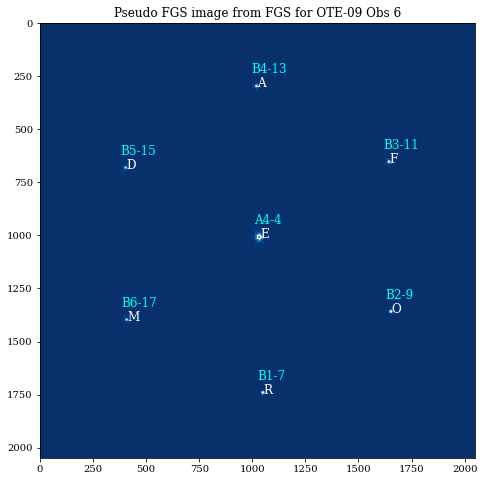

In [37]:
xs = commanded_all_psfs_table_obs5['x'].values
ys = commanded_all_psfs_table_obs5['y'].values
labels = commanded_all_psfs_table_obs5['label'].values
segments = commanded_all_psfs_table_obs5['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(commanded_pseudo_fgs_obs5, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from FGS for OTE-09 Obs 6")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-25, y-60), color='cyan', fontsize=12)
plt.show()

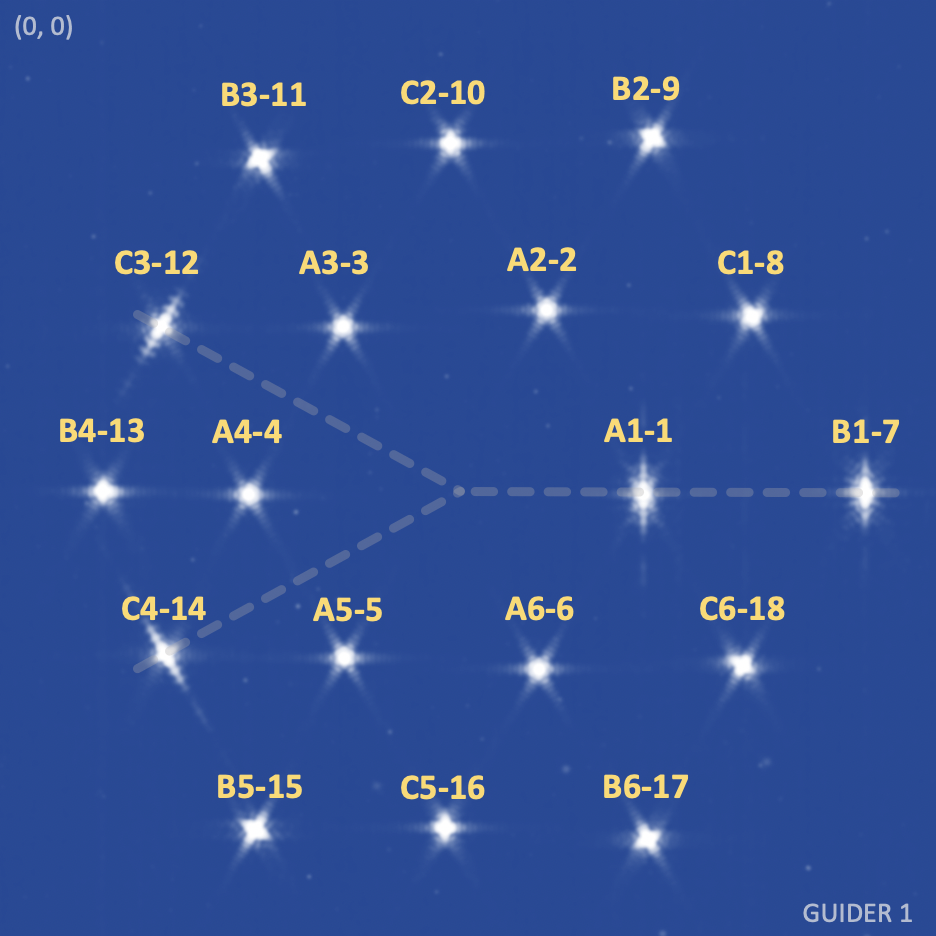

In [38]:
Image(filename=orientation_filename, height=400, width=400) 

In this case, note that `E` is actually all A segments stacked on top of each other. 

Confirm that the segments found are consistent with the diagrams above (depending on which guider is being used) and matches what is given in the all_psfs_table for the pseudo-FGS image from the ID strips. If you need to update the segment names in the table, you can do so by creating a list of the actual segment IDs in order as they appear in the table (for example called `actual_segments` and run a cell with the following lines of code: 
```
actual_segments = [,] # Fill in this list
commanded_all_psfs_table_obs5['segment'] = actual_segments
```

## Combine both tables and compare the measured 3x3 count rates 

In [39]:
# Combine tables on 'segment' and find percent difference
commanded_table_obs5 = commanded_all_psfs_table_obs5[['segment', 'countrate']].copy()
commanded_table_obs5.rename({'countrate': 'commanded_countrate'}, axis='columns', inplace=True)

# Now deal with the truth table
truth_table_obs5 = all_psfs_table_obs5[['segment', 'countrate']].copy()
truth_table_obs5.rename({'countrate': 'truth_countrate'}, axis='columns', inplace=True)

# Now combine and find the percent difference between truth and command
merged_table_obs5 = reduce(lambda left, right: pd.merge(left, right, left_on='segment',
                                                        right_on='segment'), 
                           [commanded_table_obs5, truth_table_obs5])
percent_diff = calculate_percent_diff(merged_table_obs5['truth_countrate'].values, 
                                      merged_table_obs5['commanded_countrate'].values)
merged_table_obs5['percent_difference'] = percent_diff

merged_table_obs5

segment  commanded_countrate  truth_countrate  percent_difference
0    A4-4           24312.1353       99237.4111           75.501038
1    B1-7           11228.6666       37693.9841           70.210985
2    B2-9           11782.3289      109606.0586           89.250294
3   B3-11            9606.1696       58980.4243           83.712953
4   B4-13            9403.8337       44823.6899           79.020394
5   B5-15            7836.0065       67991.6616           88.475048
6   B6-17            8055.2964      111133.5527           92.751697

**Remember!**

In observation 7, 8, 9 and 10, we will have a similar configuration but with the B segments moving around in the image. Since we are guiding on the C segments, which do not move, we do not expect the count rates of each segment PSF to change from the number measured in the pseudo-FGS image made from the ID strips. For each of these observations, continue to check that the 3x3 count rates in your command do not differ from the "truth" value by more than 30%.

# Before the start of Observation 11 

At the end of observation 10, you will have the NIRCam image from the end of observation 10, which you will run through MAGIC as normal (normalizing to the guide star) to make your command for observation 11. After you finish your DHAS testing and make your override file, download the `gs-id_1_image_cal.fits` for the end of observation 10 from MAST. The goal is to compare the 3x3 count rate of the center stack of A and B segments that you get from the pseudo-FGS image from a NIRCam image, to that from the ID strips. The values from the ID strips is considered truth since it is an FGS image looking at the actual guide star. If these values **differ by more than 30%**, replace the commanded 3x3 count rate in the override file, with what is measured in the pseudo-FGS image made from the ID strips. 

The ID image that you have retrieved from MAST is a merged image that has been run through the pipeline and is in the SCI frame. It has a size of 2028x2024 so you will pad this image to a 2048x2048 image so that can be run through MAGIC to get out the 3x3 count rates for each PSF. We will also subtract off the average background, and cut out any background stars to make sure that this image doesn't run into any issues in MAGIC. 

The biggest potential here will be saturation in either, or even both, the NIRCam and FGS ID images. **If the stack is saturated in either image, the count rates recorded *cannot be used or compared*.**

## About this Guide Star

#### NOTE: 
We assume that the guide star/guider has not changed from observation 5. If it has changed, we will not be able to compare any count rate information betweeen these observations. 

In [109]:
# If the guider and guide star information has changed, change the below Parameters
guider_obs10 = guider
guide_star_id_obs10 = guide_star_id

## Load in the ID strips merged image if it exists

If the `gs-id_1_image_cal.fits` exists in MAST for your observation, you want to use that one. This a merged ID strips image. It has the shape 2048x2024 so you will need to pad it by 24 rows of zeros. Since the positions of the PSFs don't matter in the image, this change will not negatively impact the data or our analysis. 

In [40]:
# Grab the *_gs-id_1_image_cal.fits image associated with your CAR/obs from MAST
# and provide the path to this image below

path_to_id_image_cal = '/Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits'

In [41]:
hdu = fits.open(path_to_id_image_cal)
hdu.info()

Filename: /Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        54   (2024, 2048, 1)   float32   
  2  ERR           1 ImageHDU        10   (2024, 2048, 1)   float32   
  3  DQ            1 ImageHDU        11   (2024, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


(1, 2048, 2024)


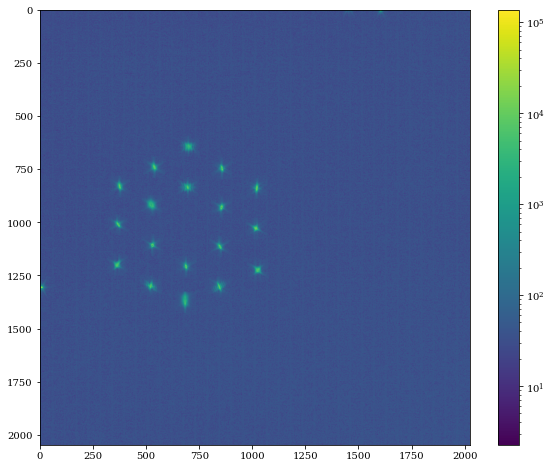

In [42]:
sci = fits.getdata(path_to_id_image_cal)
print(np.shape(sci))

plt.figure(figsize=(10,8))
plt.imshow(sci[0], norm=LogNorm())
plt.colorbar()
plt.show()

In [43]:
bk_sub_sci = sci[0] - np.median(np.asarray(sci[0])) # Remove background as much as possible

center_of_array = (690, 1000) #Eye ball the center of the array
radius_of_window = 500

cropped = bk_sub_sci[center_of_array[1]-radius_of_window: center_of_array[1]+radius_of_window,
                     center_of_array[0]-radius_of_window: center_of_array[0]+radius_of_window]

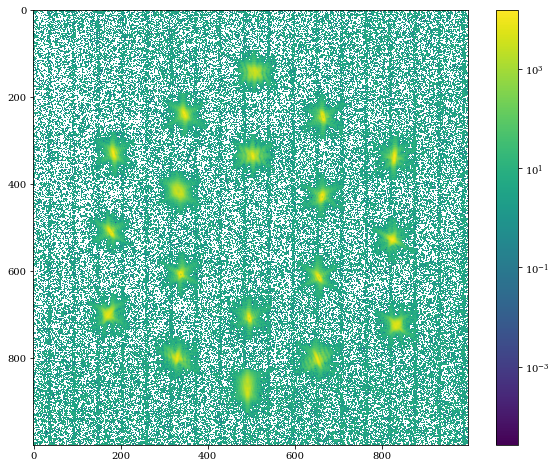

In [44]:
plt.figure(figsize=(10,8))
plt.imshow(cropped, norm=LogNorm())
plt.colorbar()
plt.show()

In [45]:
# Pad the image to a 2048x2048 image
pad = (2048 - (2*radius_of_window)) // 2
padded_sci = np.pad(cropped, pad, 'constant')

if np.shape(padded_sci) != (2048, 2048):
    print(f'The shape of the input data is not as expected ({np.shape(padded_sci)}, adjust the padding function accordingly')

In [46]:
# Make sure that the associated data is the same shape as the SCI image
err = hdu['ERR'].data
padded_err = np.pad(err[0], ((0,0), (12,12)), 'constant')
if np.shape(padded_err) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

dq = hdu['DQ'].data
padded_dq = np.pad(dq, ((0,0), (12,12)), 'constant')
if np.shape(padded_dq) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

In [47]:
# Put these back into the file that we will be using and write it out
hdu['SCI'].data = padded_sci
hdu['ERR'].data = padded_err
hdu['DQ'].data = padded_dq

path, filename = os.path.split(path_to_id_image_cal)
new_filename = f'expanded_{filename}'
outfile = os.path.join('/Users/kbrooks/Desktop', new_filename)
hdu.writeto(outfile, overwrite=True)

## Run this image through the backend of MAGIC to create a pseudo-FGS image 

In [48]:
# Input image and paths
input_image = outfile # This is the same image that you just wrote out
root = 'from_ote09_obs10_id'
out_dir = '/Users/kbrooks/Desktop/MAGIC/test/'# Change this path

# Smoothing information
smoothing = 'high' #"high" for large smoothing (e.g. Global Alignment), "default" for medium smoothing 

In [49]:
fits.info(input_image)

Filename: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        53   (2048, 2048)   float32   
  2  ERR           1 ImageHDU         9   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


In [50]:
# Create a peusdo-FGS image from the ID image
convert_id_to_fgs_raw(input_image, root, out_dir, guider_obs10, smoothing)

2021-12-30 10:37:29,689 - INFO - Started logging to file /Users/kbrooks/Desktop/MAGIC/test/out/from_ote09_obs10_id/2021_12_30_Thu_103729_main_from_ote09_obs10_id.log
2021-12-30 10:37:29,689 - INFO - Package directory: /Users/kbrooks/git_repos/jwst-magic-fork/
2021-12-30 10:37:29,690 - INFO - Processing request for from_ote09_obs10_id.
2021-12-30 10:37:29,690 - INFO - All data will be saved in: /Users/kbrooks/Desktop/MAGIC/test/out/from_ote09_obs10_id
2021-12-30 10:37:29,691 - INFO - Input image: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
2021-12-30 10:37:29,783 - INFO - Image Conversion: Beginning image conversion to guider 1 FGS image
2021-12-30 10:37:29,784 - INFO - Image Conversion: Input image is expected to be in units of ADU/sec (countrate)
2021-12-30 10:37:36,864 - INFO - Image Conversion: Bad pixels removed from image using DQ array from image.
2021-12-30 10:37:36,864 - INFO - Image Conversion: Image in correct units of ADU/s.
2021-12-30 10:37:36,877 -

In [51]:
# Make a table of the all found PSFs
#TODO: The below 3 lines are added in for testing. REMOVE FOR FLIGHT
out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/cr_comparison/ote09'
root = 'obs10_fgs_new'
## Remove above 3 lines for flight

all_psfs_filename_obs10 = os.path.join(out_dir, 'out', root, f'unshifted_all_found_psfs_{root}_G{guider_obs10}.txt')
all_psfs_table_obs10 = read_all_found_psfs(all_psfs_filename_obs10)

all_psfs_table_obs10

label segment       y       x     countrate
7     L    A2-2  1340.0  1246.0  4.733960e+05
4     H    A3-3  1011.0  1235.0  5.235825e+06
3     G    A5-5   862.0   953.0  2.601299e+05
6     K    A6-6  1186.0   956.0  2.820122e+05
2     F   B3-11   851.0  1508.0  3.260692e+05
5     J   C2-10  1168.0  1514.0  5.238065e+05
1     C   C3-12   692.0  1229.0  3.097507e+05
0     B   C4-14   496.0   825.0  9.864026e+04
8     P   C6-18  1794.0   778.0  9.522985e+05

In [52]:
#TODO: remove this line for the real data
# Use this line if MAGIC found PSFs that are not part of the guide star
all_psfs_table_obs10 = all_psfs_table_obs10.drop([0, 8], axis=0)

### Do a quick visual check to make sure that the identified segments are correct 

In [53]:
pseudo_fgs_obs10 = fits.getdata(os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                                             f'unshifted_{root}_G{guider_obs10}.fits'))

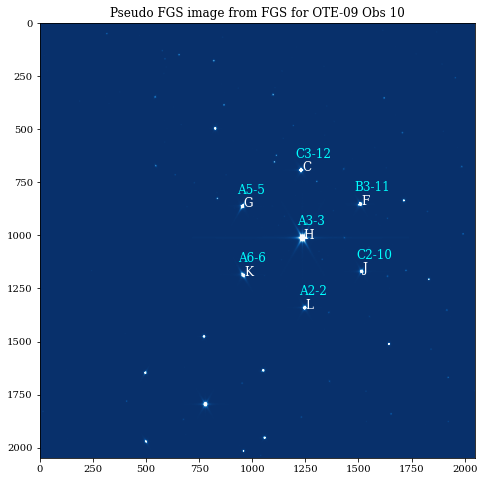

In [54]:
xs = all_psfs_table_obs10['x'].values
ys = all_psfs_table_obs10['y'].values
labels = all_psfs_table_obs10['label'].values
segments = all_psfs_table_obs10['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from FGS for OTE-09 Obs 10")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-25, y-60), color='cyan', fontsize=12)
plt.show()

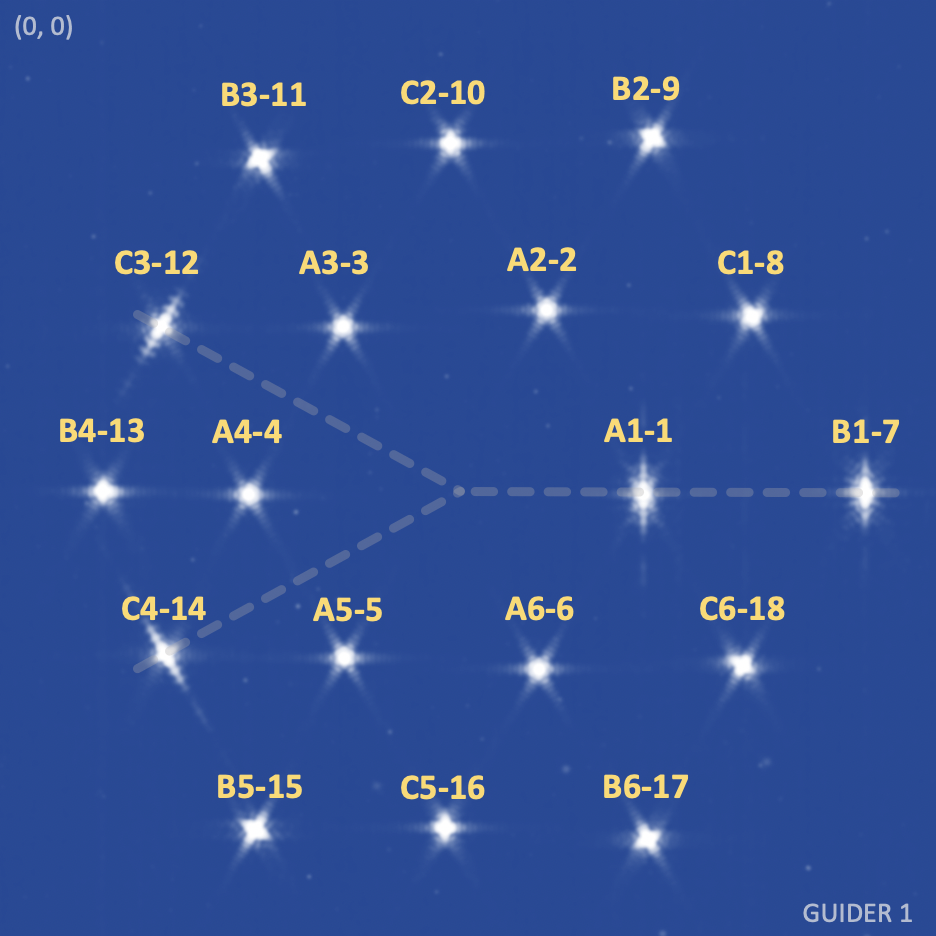

In [55]:
Image(filename=orientation_filename, height=400, width=400) 

Confirm that the segments found are consistent with the diagrams above (depending on which guider is being used) and matches what is given in the all_psfs_table for the pseudo-FGS image from the ID strips. If you need to update the segment names in the table, you can do so by creating a list of the actual segment IDs in order as they appear in the table (for example called `actual_segments` and run a cell with the following lines of code: 
```
actual_segments = [,] # Fill in this list
commanded_all_psfs_table_obs10['segment'] = actual_segments
```

In [56]:
actual_segments = ['C5-16', 'stack', 'C3-12', 'C4-14', 'C1-8', 'C6-18', 'C2-10']
all_psfs_table_obs10['segment'] = actual_segments
all_psfs_table_obs10 = all_psfs_table_obs10.sort_values('segment', ascending=True)
all_psfs_table_obs10

label segment       y       x     countrate
2     F    C1-8   851.0  1508.0  3.260692e+05
1     C   C2-10   692.0  1229.0  3.097507e+05
3     G   C3-12   862.0   953.0  2.601299e+05
6     K   C4-14  1186.0   956.0  2.820122e+05
7     L   C5-16  1340.0  1246.0  4.733960e+05
5     J   C6-18  1168.0  1514.0  5.238065e+05
4     H   stack  1011.0  1235.0  5.235825e+06

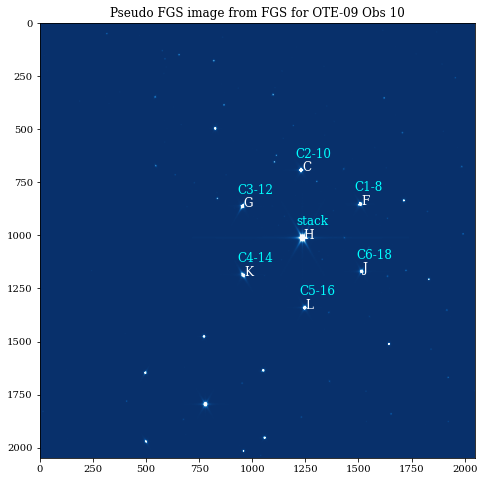

In [57]:
xs = all_psfs_table_obs10['x'].values
ys = all_psfs_table_obs10['y'].values
labels = all_psfs_table_obs10['label'].values
segments = all_psfs_table_obs10['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from FGS for OTE-09 Obs 10")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-25, y-60), color='cyan', fontsize=12)
plt.show()

## Load in your commanded all found PSFs file

In [58]:
# Input image and paths
root = 'obs10_nircam_track_new'
out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/cr_comparison/ote09'

In [59]:
# Make a table of the all found PSFs
commanded_all_psfs_filename_obs10 = os.path.join(out_dir, 'out', root, 
                                                 f'unshifted_all_found_psfs_{root}_G{guider_obs10}.txt')
commanded_all_psfs_table_obs10 = read_all_found_psfs(commanded_all_psfs_filename_obs10)

commanded_all_psfs_table_obs10

label segment       y       x     countrate
3     E    A4-4  1011.0  1029.0  3.793331e+06
6     R    B1-7  1339.0  1037.0  3.551203e+05
4     O    B2-9  1169.0  1309.0  3.750821e+05
1     F   B3-11   851.0  1305.0  3.247049e+05
0     A   B4-13   692.0  1024.0  3.133427e+05
2     D   B5-15   864.0   747.0  2.473798e+05
5     M   B6-17  1186.0   749.0  2.483148e+05

In [60]:
commanded_pseudo_fgs_obs10 = fits.getdata(os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                                                       f'unshifted_{root}_G{guider_obs10}.fits'))

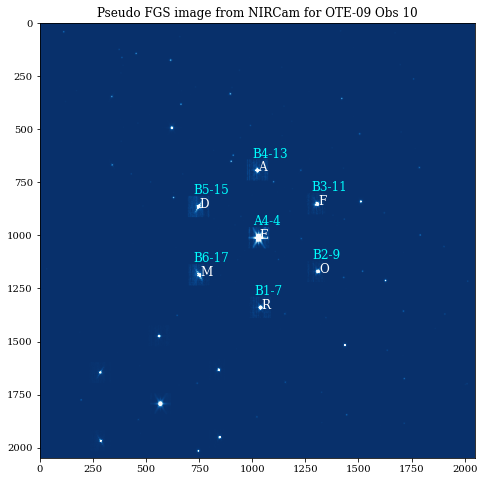

In [61]:
xs = commanded_all_psfs_table_obs10['x'].values
ys = commanded_all_psfs_table_obs10['y'].values
labels = commanded_all_psfs_table_obs10['label'].values
segments = commanded_all_psfs_table_obs10['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(commanded_pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from NIRCam for OTE-09 Obs 10")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-25, y-60), color='cyan', fontsize=12)
plt.show()

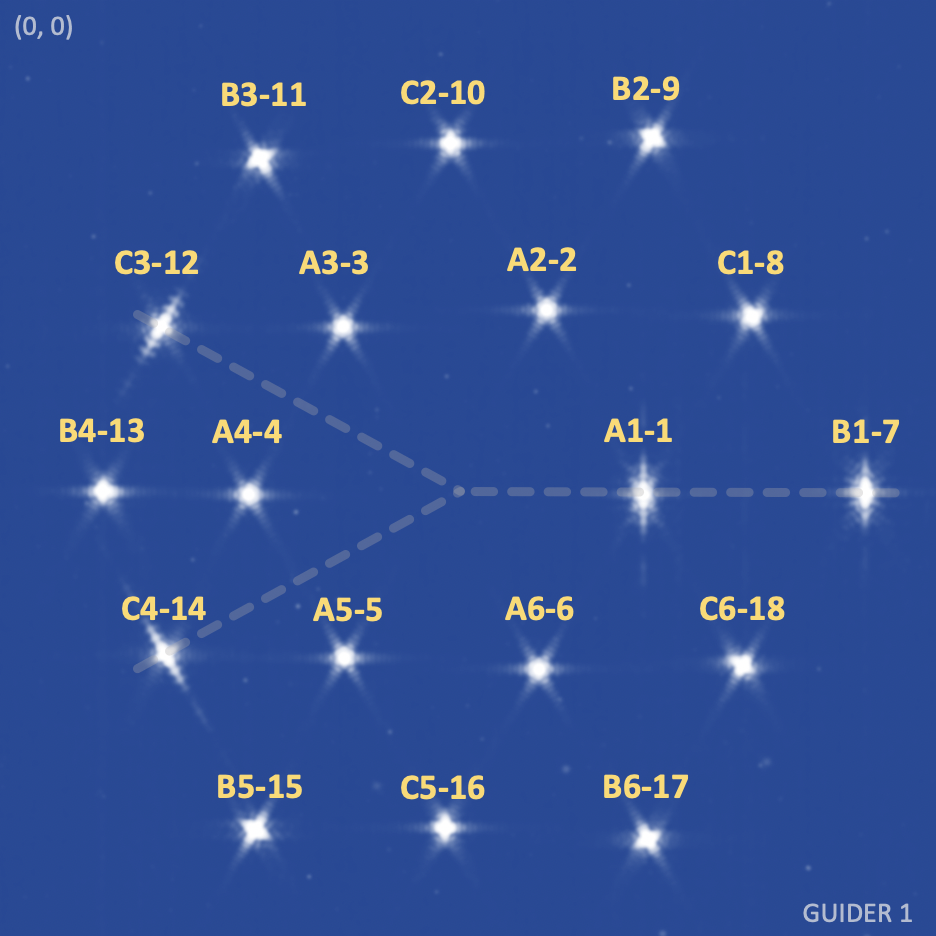

In [62]:
Image(filename=orientation_filename, height=400, width=400) 

It looks like the segments were incorrectly identified, let's fix that! I will rename the stacked segments to "stack" in the table, so that we know that this is all the A and B segments

In [63]:
actual_segments = ['stack', 'C5-16', 'C6-18', 'C1-8', 'C2-10', 'C3-12', 'C4-14']
commanded_all_psfs_table_obs10['segment'] = actual_segments
commanded_all_psfs_table_obs10 = commanded_all_psfs_table_obs10.sort_values('segment', ascending=True)
commanded_all_psfs_table_obs10

label segment       y       x     countrate
1     F    C1-8   851.0  1305.0  3.247049e+05
0     A   C2-10   692.0  1024.0  3.133427e+05
2     D   C3-12   864.0   747.0  2.473798e+05
5     M   C4-14  1186.0   749.0  2.483148e+05
6     R   C5-16  1339.0  1037.0  3.551203e+05
4     O   C6-18  1169.0  1309.0  3.750821e+05
3     E   stack  1011.0  1029.0  3.793331e+06

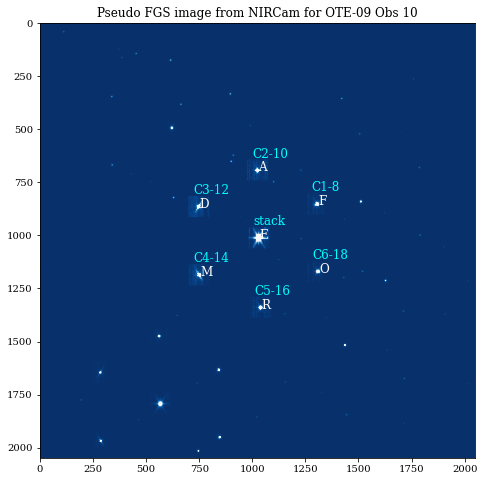

In [64]:
xs = commanded_all_psfs_table_obs10['x'].values
ys = commanded_all_psfs_table_obs10['y'].values
labels = commanded_all_psfs_table_obs10['label'].values
segments = commanded_all_psfs_table_obs10['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(commanded_pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from NIRCam for OTE-09 Obs 10")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-25, y-60), color='cyan', fontsize=12)
plt.show()

## Combine both tables and compare the measured 3x3 count rates 

In [65]:
# Combine tables on 'segment' and find percent difference
commanded_table_obs10 = commanded_all_psfs_table_obs10[['segment', 'countrate']].copy()
commanded_table_obs10.rename({'countrate': 'commanded_countrate'}, axis='columns', inplace=True)

# Now deal with the truth table
truth_table_obs10 = all_psfs_table_obs10[['segment', 'countrate']].copy()
truth_table_obs10.rename({'countrate': 'truth_countrate'}, axis='columns', inplace=True)

# Now combine and find the percent difference between truth and command
merged_table_obs10 = reduce(lambda left, right: pd.merge(left, right, left_on='segment',
                                                         right_on='segment'), 
                            [commanded_table_obs10, truth_table_obs10])
percent_diff = calculate_percent_diff(merged_table_obs10['truth_countrate'].values, 
                                      merged_table_obs10['commanded_countrate'].values)
merged_table_obs10['percent_difference'] = percent_diff

merged_table_obs10

segment  commanded_countrate  truth_countrate  percent_difference
0    C1-8         3.247049e+05     3.260692e+05            0.418426
1   C2-10         3.133427e+05     3.097507e+05            1.159644
2   C3-12         2.473798e+05     2.601299e+05            4.901413
3   C4-14         2.483148e+05     2.820122e+05           11.948900
4   C5-16         3.551203e+05     4.733960e+05           24.984525
5   C6-18         3.750821e+05     5.238065e+05           28.393010
6   stack         3.793331e+06     5.235825e+06           27.550457

## Is the center stack saturated? 

First thing, check the image, either in DS9, or by plotting it out here

In [66]:
stacked_row = all_psfs_table_obs10.loc[all_psfs_table_obs10['segment']=='stack']
stacked_x = stacked_row['x'].values[0]
stacked_y = stacked_row['y'].values[0]

commanded_stacked_row = commanded_all_psfs_table_obs10.loc[commanded_all_psfs_table_obs10['segment']=='stack']
commanded_stacked_x = commanded_stacked_row['x'].values[0]
commanded_stacked_y = commanded_stacked_row['y'].values[0]

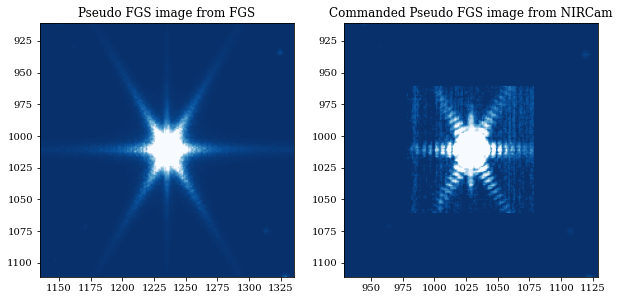

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
ax[0].set_title(f"Pseudo FGS image from FGS")
ax[0].set_xlim(stacked_x-100, stacked_x+100)
ax[0].set_ylim(stacked_y+100, stacked_y-100)

ax[1].imshow(commanded_pseudo_fgs_obs10, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
ax[1].set_title(f"Commanded Pseudo FGS image from NIRCam")
ax[1].set_xlim(commanded_stacked_x-100, commanded_stacked_x+100)
ax[1].set_ylim(commanded_stacked_y+100, commanded_stacked_y-100)
plt.show()

### No...

If the stack is not saturated at all, use the recorded 3x3 count rate to either compare to the pusedo-FGS image made from the NIRCam image (if the stack in the NIRCam image is also not saturated). If the stack is saturated in the NIRCam image, you will use the 3x3 count rate measured from the ID image. 

In this case you will **create a SOF** since we have everything we need to make our SOF.

### Yes... 

If the FGS image shows a saturated core, then we don't have a "truth" 3x3 count rate for the center stack. 

We can try to piece together what the count rate is based on the images we have so far.

In this case you will **create a POF** since we will now calculate a count rate factor and count rate uncertainty factor. 

### Grab count rate from the catalog 

In [112]:
# Check that the guider and Guide Star ID HAVE NOT CHANGED between observations
if guide_star_id != guide_star_id_obs10 or guider != guider_obs10:
    print("The guide star has changed between Observation 5 and 10. No meaningful comparison can be made ",
          "between the data")
else:
    print("The guide star hasn't changed so please continue with the following cells")

The guide star hasn't changed so please continue with the following cells


In [79]:
fgs = fgscountrate.FGSCountrate(guide_star_id=guide_star_id, guider=guider) 
catalog_count_rate, _, magnitude, _ = fgs.query_fgs_countrate_magnitude()

print(f"Catalog count rate for {guide_star_id} in guider {guider}: {catalog_count_rate} ADU/s")

Catalog count rate for N4ED000133 in guider 1: 28508980.06901523 ADU/s


In [113]:
magnitude

10.297041432675723

### Look at obs 5 data first 

In [75]:
all_psfs_table_obs5

label segment       y       x    countrate
8      N    A1-1  1018.0  1189.0   92530.4463
4      L    A2-2   859.0  1095.0   98461.8320
5      H    A3-3   867.0   910.0   88735.8672
9      E    A4-4  1026.0   816.0   99237.4111
12     G    A5-5  1184.0   917.0   80349.1865
13     K    A6-6  1189.0  1106.0   34408.5588
7      R    B1-7  1014.0  1381.0   37693.9841
1      O    B2-9   693.0  1185.0  109606.0586
0      F   B3-11   688.0   800.0   58980.4243
10     A   B4-13  1031.0   654.0   44823.6899
17     D   B5-15  1350.0   824.0   67991.6616
15     M   B6-17  1338.0  1194.0  111133.5527
3      Q    C1-8   857.0  1278.0   91302.4785
2      J   C2-10   697.0   996.0  119059.1846
6      C   C3-12   869.0   721.0   87203.8560
14     B   C4-14  1192.0   724.0   75792.5586
16     I   C5-16  1345.0  1014.0   86409.3013
11     P   C6-18  1175.0  1284.0   95949.3027

In [83]:
# Add up all the count rates (stacked and unstacked segments) - AS LONG AS *NO* SATURATION
# As - we expect these to be in a stack, but the labels could still be one of the A labels so we check for all
obs5_as = all_psfs_table_obs5.loc[all_psfs_table_obs5['segment'].isin(['A1-1', 'A2-2', 'A3-3', 'A4-4', 
                                                                       'A5-5', 'A6-6', 'stack'])]
obs5_as_countrates = obs5_as['countrate'].values
obs5_as_sum = obs5_as_countrates.sum()

obs5_as

label segment       y       x   countrate
8      N    A1-1  1018.0  1189.0  92530.4463
4      L    A2-2   859.0  1095.0  98461.8320
5      H    A3-3   867.0   910.0  88735.8672
9      E    A4-4  1026.0   816.0  99237.4111
12     G    A5-5  1184.0   917.0  80349.1865
13     K    A6-6  1189.0  1106.0  34408.5588

In [84]:
# Bs
obs5_bs = all_psfs_table_obs5.loc[all_psfs_table_obs5['segment'].isin(['B1-7', 'B2-9', 'B3-11', 'B4-13', 
                                                                       'B5-15', 'B6-17'])]
obs5_bs_countrates = obs5_bs['countrate'].values
obs5_bs_sum = obs5_bs_countrates.sum()

obs5_bs

label segment       y       x    countrate
7      R    B1-7  1014.0  1381.0   37693.9841
1      O    B2-9   693.0  1185.0  109606.0586
0      F   B3-11   688.0   800.0   58980.4243
10     A   B4-13  1031.0   654.0   44823.6899
17     D   B5-15  1350.0   824.0   67991.6616
15     M   B6-17  1338.0  1194.0  111133.5527

In [85]:
# Cs
obs5_cs = all_psfs_table_obs5.loc[all_psfs_table_obs5['segment'].isin(['C1-8', 'C2-10', 'C3-12', 'C4-14', 
                                                                       'C5-16', 'C6-18'])]
obs5_cs_countrates = obs5_cs['countrate'].values
obs5_cs_sum = obs5_cs_countrates.sum()

obs5_cs

label segment       y       x    countrate
3      Q    C1-8   857.0  1278.0   91302.4785
2      J   C2-10   697.0   996.0  119059.1846
6      C   C3-12   869.0   721.0   87203.8560
14     B   C4-14  1192.0   724.0   75792.5586
16     I   C5-16  1345.0  1014.0   86409.3013
11     P   C6-18  1175.0  1284.0   95949.3027

In [92]:
obs5_as_bs_sum = obs5_as_sum + obs5_bs_sum
print(f"Based on the numbers from the A and B segments in observation 5, the APPROXIMATE",
      f"3x3 count rate of the As and Bs is {obs5_as_bs_sum}")

Based on the numbers from the As and Bs in obs 5, the APPROXIMATE 3x3 count rate of the As and Bs is 923952.6731


In [93]:
print(f"The sum of the C segments 3x3 count rates for observation 5 is {obs5_cs_sum}")

The sum of the C segments 3x3 count rates for observation 5 is 555716.6817000001


### Now sum the segments in obs 10 

In [68]:
all_psfs_table_obs10

label segment       y       x     countrate
2     F    C1-8   851.0  1508.0  3.260692e+05
1     C   C2-10   692.0  1229.0  3.097507e+05
3     G   C3-12   862.0   953.0  2.601299e+05
6     K   C4-14  1186.0   956.0  2.820122e+05
7     L   C5-16  1340.0  1246.0  4.733960e+05
5     J   C6-18  1168.0  1514.0  5.238065e+05
4     H   stack  1011.0  1235.0  5.235825e+06

In [70]:
obs10_segment_countrates = all_psfs_table_obs10['countrate'].values[:-1]
obs10_cr_sum = obs10_segment_countrates.sum()
obs10_cr_sum

2175164.4594

In [94]:
# Add up all the count rates (stacked and unstacked segments) - AS LONG AS *NO* SATURATION
# As & Bs
# we expect these to be in a stack, but the labels could still be one of the A or B labels so we check for all
obs10_stack = all_psfs_table_obs10.loc[all_psfs_table_obs10['segment'].isin(['A1-1', 'A2-2', 'A3-3', 'A4-4', 
                                                                             'A5-5', 'A6-6', 'B1-7', 'B2-9', 
                                                                             'B3-11', 'B4-13', 'B5-15', 'B6-17',
                                                                             'stack'])]
obs10_stack_countrates = obs10_stack['countrate'].values
obs10_stack_sum = obs10_stack_countrates.sum()

obs10_stack

label segment       y       x     countrate
4     H   stack  1011.0  1235.0  5.235825e+06

In [95]:
# Cs
obs10_cs = all_psfs_table_obs10.loc[all_psfs_table_obs10['segment'].isin(['C1-8', 'C2-10', 'C3-12', 'C4-14', 
                                                                          'C5-16', 'C6-18'])]
obs10_cs_countrates = obs10_cs['countrate'].values
obs10_cs_sum = obs10_cs_countrates.sum()

obs10_cs

label segment       y       x    countrate
2     F    C1-8   851.0  1508.0  326069.2224
1     C   C2-10   692.0  1229.0  309750.6510
3     G   C3-12   862.0   953.0  260129.8541
6     K   C4-14  1186.0   956.0  282012.1825
7     L   C5-16  1340.0  1246.0  473396.0065
5     J   C6-18  1168.0  1514.0  523806.5429

In [96]:
print(f"Based on the numbers from the A and B segments in observation 10, the SATURATED",
      f"3x3 count rate of the As and Bs is {obs10_stack_sum}")

Based on the numbers from the A and B segments in observation 10, the SATURATED 3x3 count rate of the As and Bs is 5235824.5644


In [97]:
print(f"The sum of the C segments 3x3 count rates for observation 10 is {obs10_cs_sum}")

The sum of the C segments 3x3 count rates for observation 10 is 2175164.4594


#### Compare the Cs from observation 5 and 10 and make sure they are similar 

In [98]:
calculate_percent_diff(obs5_cs_sum, obs10_cs_sum)

291.4160814366642

As long as the above values are within 10%, then continue. **If they are not, it is time to bring in others on this conversation.**

#### Calculate a count rate factor from the summed A and B segments from observation 5 

In [104]:
count_rate_factor = obs5_as_bs_sum / catalog_count_rate
print(f"Count rate factor for observation 11: {np.round(count_rate_factor, 5)}")
print("The count rate uncertainty factor (threshold) for observation 11 is 0.9")

Count rate factor for observation 11: 0.03241
The count rate uncertainty factor (threshold) for observation 11 is 0.9


If guiding is successful in observation we will have FGS track data which can now be used to make our override file. 

# After Observation 11

Since we will be guiding on the stack in observation 10, we will (if guiding is successful) have the previous observation FGS track images for observations 12, 13, 14, and 15. Note that the C segments are not stacked on top of the stack until observation 15, so the same override command can be used for observation 12, 13, and 14.

**Verify if POFs for all remaining observations** 

**For observation 15, use a count rate uncertainty factor (threshold) of 0.9** since the final 6 segments will be stacked on top of the A and B segments. 

# About this notebook

Author: K. Brooks

Last updated: 29 Dec, 2021